<a href="https://colab.research.google.com/github/vanle2000/Titanic/blob/main/Titanic_Disaster.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [102]:
pip install category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [103]:
import pandas as pd
import seaborn as sns 
%pylab inline 
import re 
import category_encoders as ce

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

Populating the interactive namespace from numpy and matplotlib


# 1. Data preprocessing

## 1.1. Importing Data

In [104]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
titanic_df = [train, test]

## 1.2. Handing Missing Values:

In [105]:
train.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [107]:
test.head(5)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [108]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Dropping the `Cabin` column, since there is 687 missing values.

In [109]:
train.drop('Cabin', axis=1, inplace=True)
train.drop('PassengerId', axis=1, inplace=True)

In [110]:
train.columns

Index(['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket',
       'Fare', 'Embarked'],
      dtype='object')

Next, using `Imputation` technique to treat `Age` and `Embarked` columns with the purpose to fill in missing values with estimated values based on available data. There are mulitple methods for imputing missing data, including:


*   Mean or median imputation: involves filling in missing values with `mean` or `median` value of the variable.
*   Mode imputation: involves filling in missing values with the most common value (`mode`) of the variable.
*   Regression imputation: involves predicting the missing values using `regression` based on the other variables of the dataset. 
*   K-nearest neighbor imputation: involves finding the `k-nearest neighbors` to the observation with missing values and filling in the missing values with the average of those neighbors.
*   Multiple imputation: involves generating multiple imputed datasets by creating pausible values for the missing values based on `statistical models`, and using these datasets to estimate parameters and make predictions. 


Imputing the `Age` column with the `median` value

In [113]:
train['Age'].fillna(train['Age'].median(), inplace=True)

Imputing the `Embrarked` column with the mode value

In [112]:
train['Embarked'].fillna(train['Embarked'].mode()[0], inplace=True)

Checking for missing values to confirm all missing values in training set have been handled.

In [115]:
train.isnull().sum()

Survived    0
Pclass      0
Name        0
Sex         0
Age         0
SibSp       0
Parch       0
Ticket      0
Fare        0
Embarked    0
dtype: int64

## 1.3. Encoding Categorical Variables
There are various method to encode the categorical variables, in this Titanic dataset, we will work with `one-hot encoding` and `leave one out encoding (LOOE)`. 


In [114]:
cat_vars = ['Sex', 'Embarked']

# Perform one-hot encoding
encoder = ce.OneHotEncoder(cols=cat_vars,
                           handle_unknown='return_nan',
                           return_df=True,
                           use_cat_names=True)

train_encoded = encoder.fit_transform(train)
train_encoded.head(5)

,Survived,Pclass,Name,Sex_male,Sex_female,Age,SibSp,Parch,Ticket,Fare,Embarked_S,Embarked_C,Embarked_Q
0,0,3,"Braund, Mr. Owen Harris",1.0,0.0,22.0,1,0,A/5 21171,7.2500,1.0,0.0,0.0
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0.0,1.0,38.0,1,0,PC 17599,71.2833,0.0,1.0,0.0
2,1,3,"Heikkinen, Miss. Laina",0.0,1.0,26.0,0,0,STON/O2. 3101282,7.9250,1.0,0.0,0.0
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0.0,1.0,35.0,1,0,113803,53.1000,1.0,0.0,0.0
4,0,3,"Allen, Mr. William Henry",1.0,0.0,35.0,0,0,373450,8.0500,1.0,0.0,0.0


In [73]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.361582,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,13.019697,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [33]:
train = train.drop('PassengerId', axis=1)

array([[<Axes: title={'center': 'Survived'}>,
        <Axes: title={'center': 'Pclass'}>],
       [<Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'SibSp'}>],
       [<Axes: title={'center': 'Parch'}>,
        <Axes: title={'center': 'Fare'}>]], dtype=object)

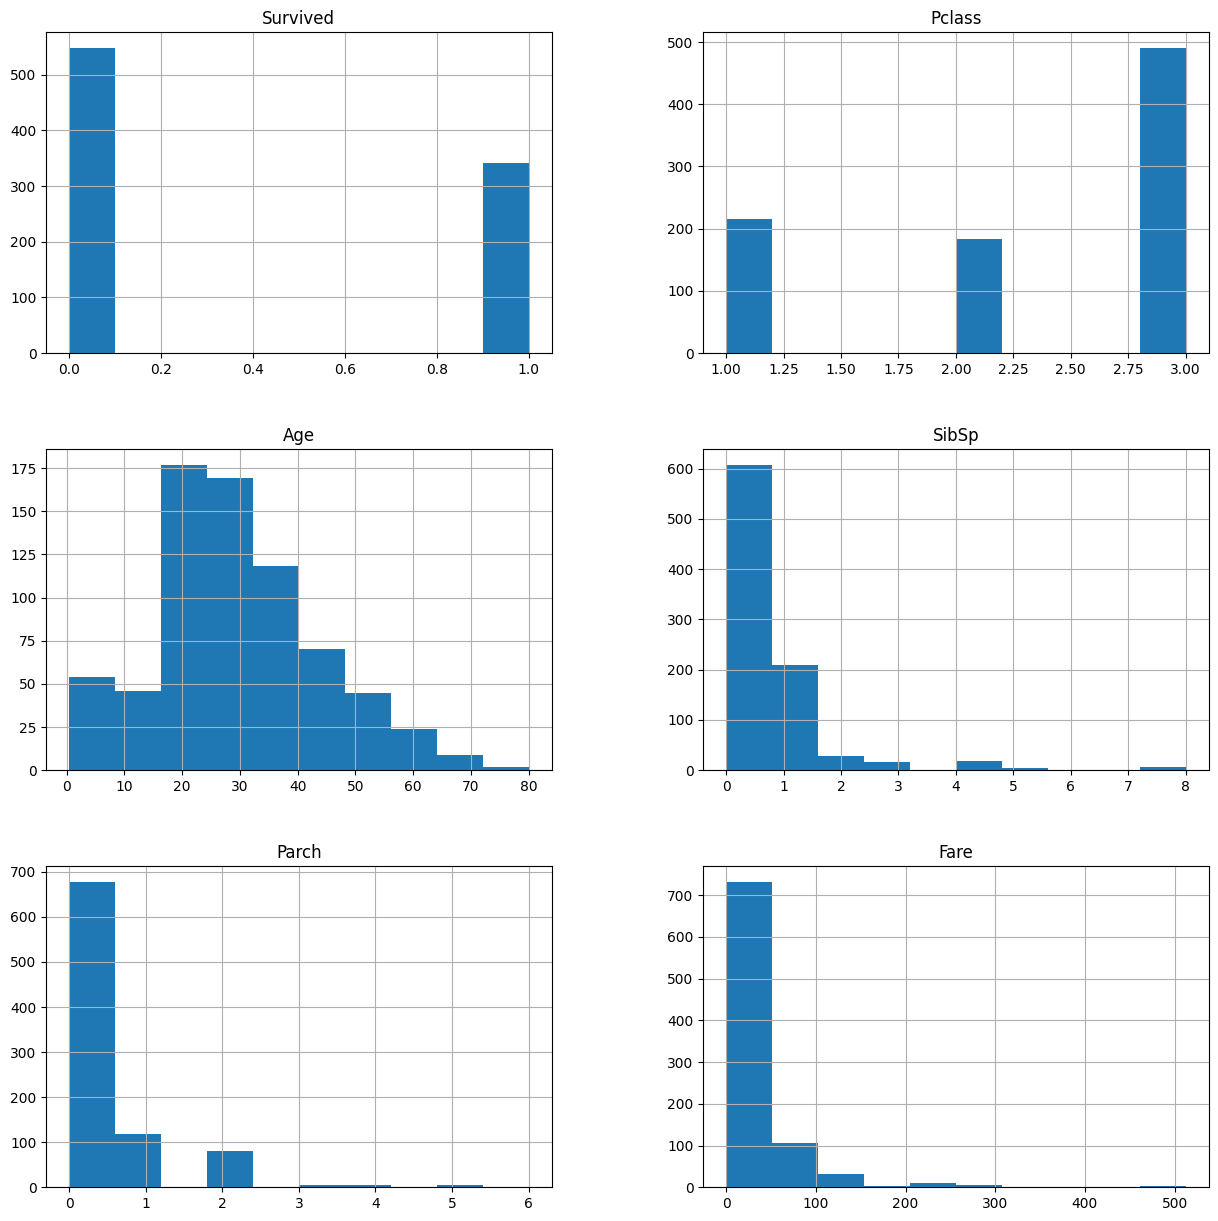

In [34]:
train.hist(figsize=(15,15))

## 1.4. Feature Engineering

In [81]:
def missing_value(colName):
  print(str(train[colName].isnull().sum()) + " null values out of " + str(len(train)) + " in training data.")
  print(str(test[colName].isnull().sum()) + " null values out of " + str(len(test)) + " in test data.")

### Name: Title Extraction

In [19]:
missing_value('Name')

0 null values out of 891 in training data.
0 null values out of 418 in test data.


In [20]:
# Title Extraction
def extract_title(Name):
  title_pattern = r", \s*([^\.]*)\."
  return re.search(title_pattern, Name).group(1)

# Split the title from the Titanic dataset
for dataset in titanic_df:
  dataset['Title'] = dataset['Name'].apply(extract_title)

In [21]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr


In [22]:
train['Title'].value_counts()

Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Mlle              2
Major             2
Col               2
the Countess      1
Capt              1
Ms                1
Sir               1
Lady              1
Mme               1
Don               1
Jonkheer          1
Name: Title, dtype: int64

In [23]:
# Recategorize title 
for dataset in titanic_df:
  dataset['Title'] = dataset['Title'].replace( ['Jonkheer', 'Don', 'Sir', 'Capt', 'Col', 'Major', 'Rev', 'Dr'], 'Mr')
  dataset['Title'] = dataset['Title'].replace( ['Mme', 'the Countess'], 'Mrs')
  dataset['Title'] = dataset['Title'].replace( ['Lady', 'Ms', 'Mlle'], 'Miss')

In [24]:
train['Title'].value_counts()

Mr        538
Miss      186
Mrs       127
Master     40
Name: Title, dtype: int64

### Define Family relationship

In [26]:
# missing value in 'Cabin' column
missing_value('Cabin')

687 null values out of 891 in training data.
327 null values out of 418 in test data.


In [ ]:
X_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=20)